# Calculate titers of spike-pseudotyped lentiviruses

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE
from mizani.formatters import scientific_format

import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config


In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [5]:
titers = pd.read_csv(config['virus_titers_antibody'])

titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,amphoB,RLUperuL
rep1,A222N,0.25000,25.000,292100.0,20250623,293T_ACE2_medium,with_amphoB,11684.000000
rep1,A222N,0.07350,7.350,102500.0,20250623,293T_ACE2_medium,with_amphoB,13945.578231
rep1,A222N,0.02160,2.160,23330.0,20250623,293T_ACE2_medium,with_amphoB,10800.925926
rep1,A222N,0.00636,0.636,8702.0,20250623,293T_ACE2_medium,with_amphoB,13682.389937
rep1,A222N,0.00187,0.187,1504.0,20250623,293T_ACE2_medium,with_amphoB,8042.780749


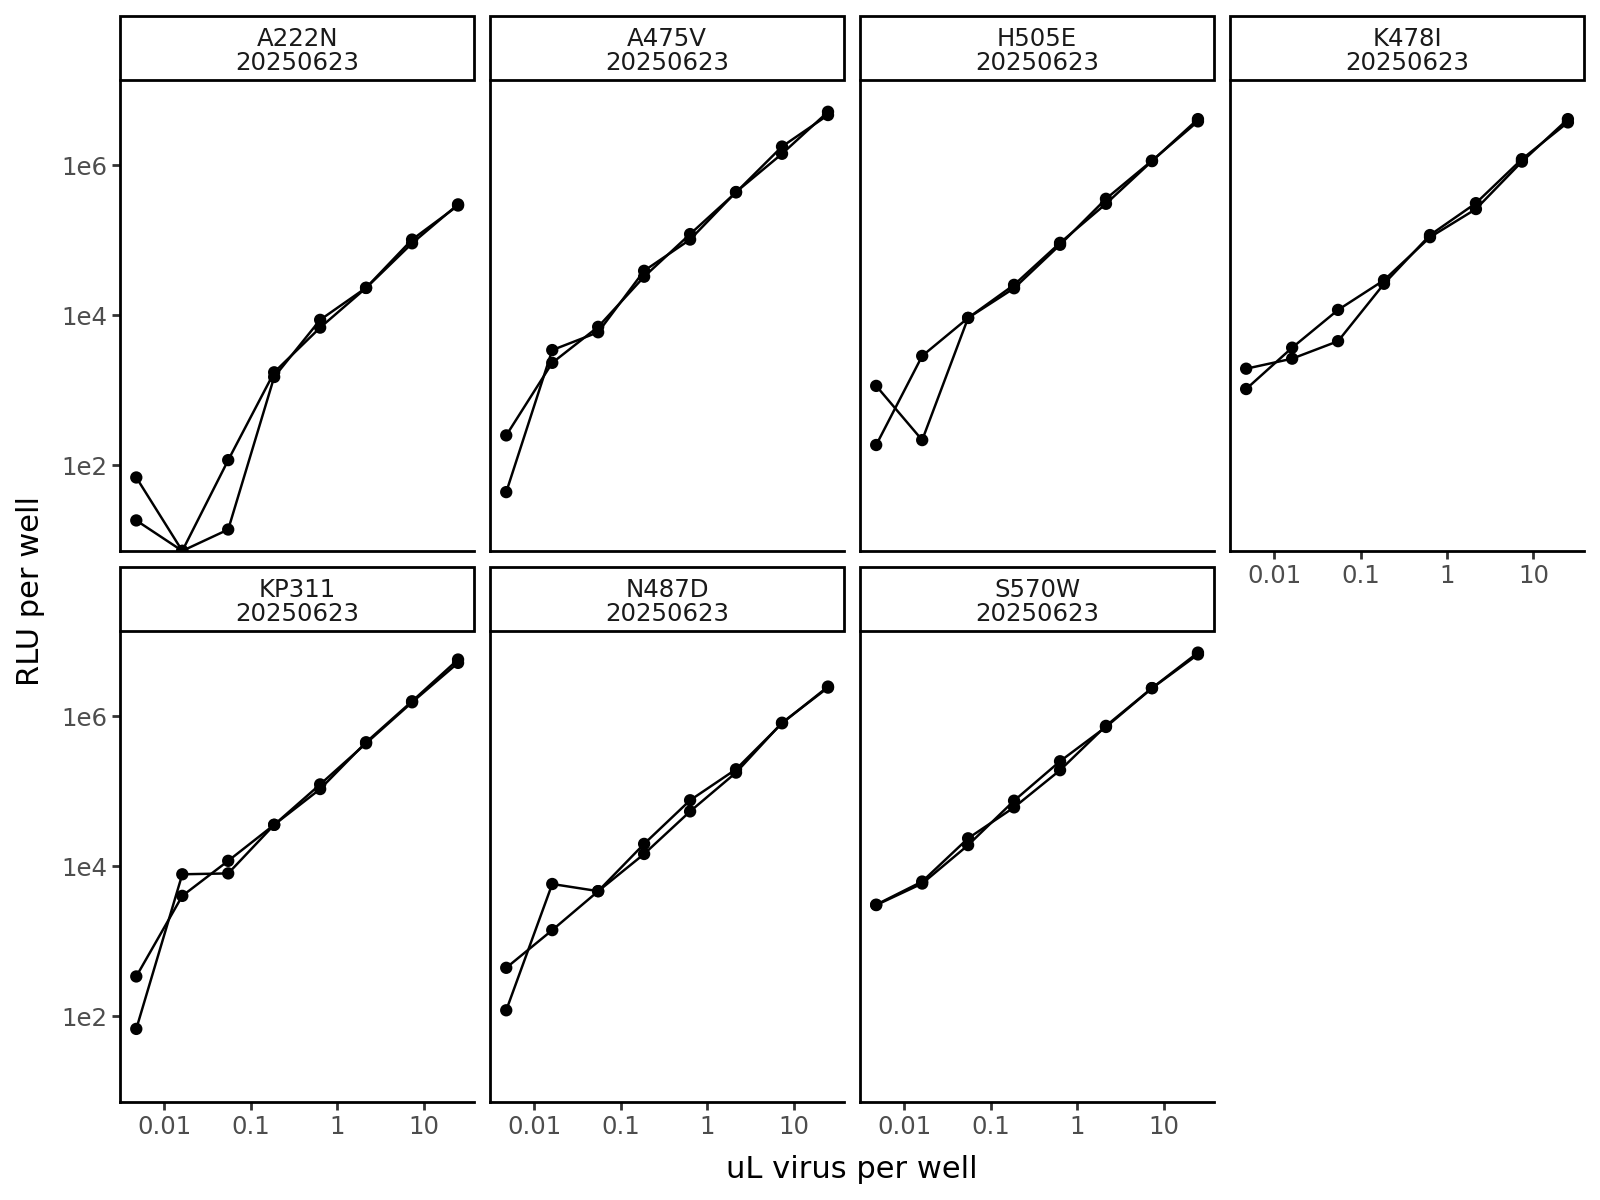

In [9]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date', ncol=4) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(8,6),
           )
     )

p

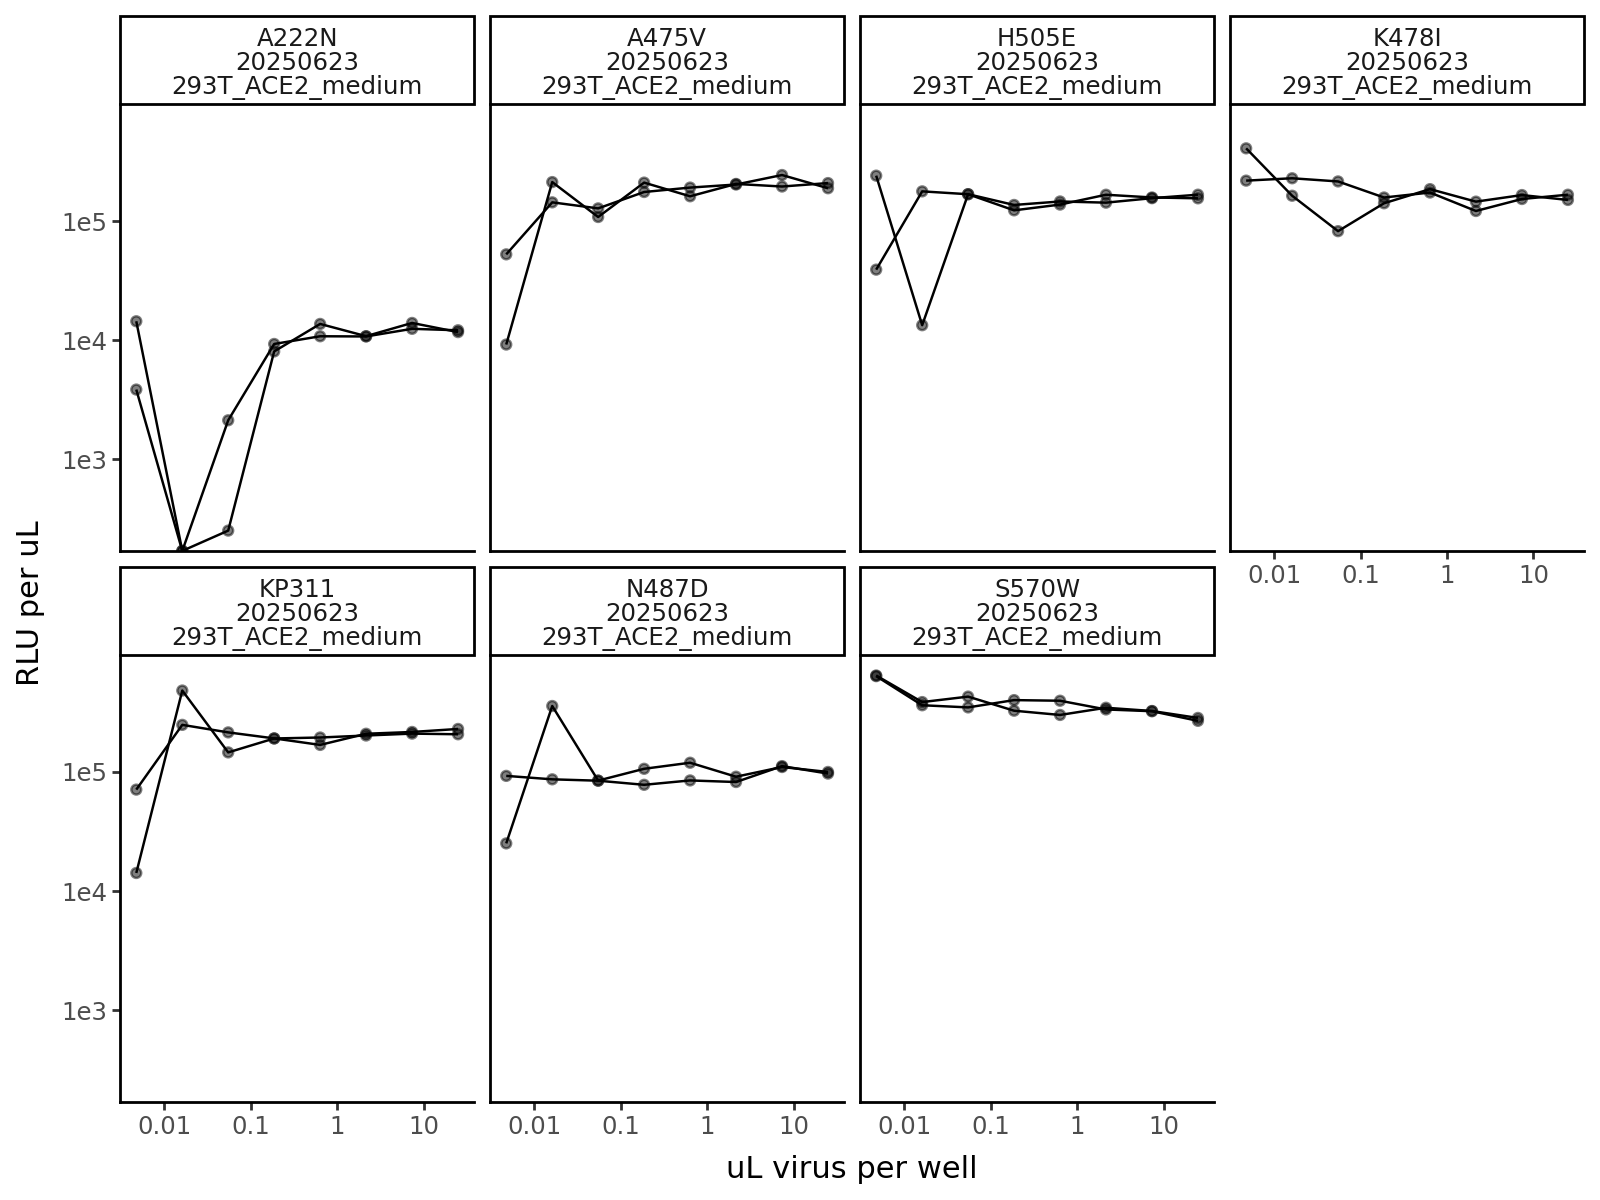

In [10]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5, alpha=0.5) +
     geom_line() +
     facet_wrap('~virus+date+cells', ncol=4) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(8,6),
           ) 
     )

p

Check that above plots are approximately linear 

In [11]:
average_titers = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop concentrations that would not be linear
                  .groupby(['virus', 'date'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,date,mean_RLUperuL
A222N,20250623,11954.264172
A475V,20250623,207007.292769
H505E,20250623,157239.978584
K478I,20250623,150266.141345
KP311,20250623,212315.408163


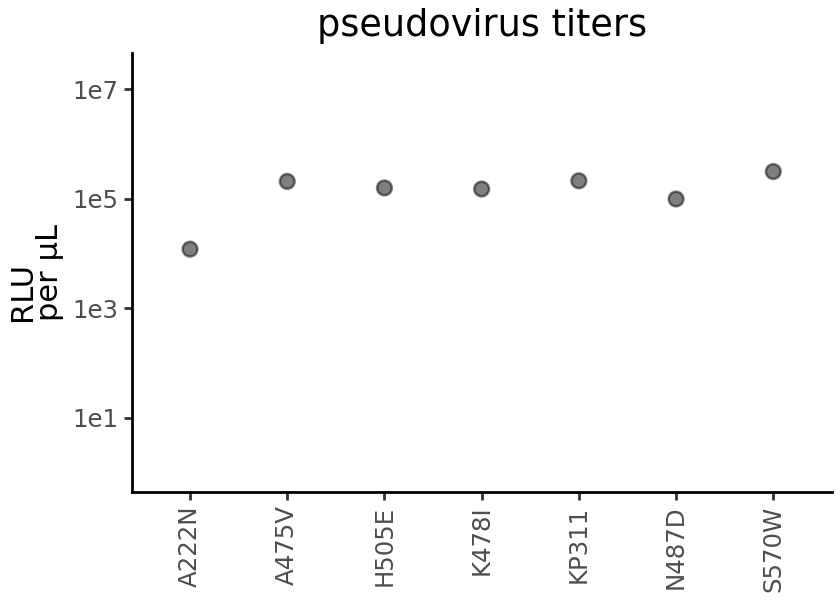

In [12]:
p = (ggplot(average_titers, 
            aes(x='virus', y='mean_RLUperuL')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*.6,3),
           axis_title_x=element_blank()
          ) +
     scale_y_log10(limits=[1,2e7]) +
     ylab('RLU\nper µL')+
     labs(title='pseudovirus titers') +
     scale_color_manual(values=CBPALETTE)
    )

p

Calculate how much virus to use in neut assays:

In [13]:
target_RLU = 5e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_12mL = lambda x: 12000/x['dilution_factor'],
                        media_for_12ml = lambda x: 12000 - 12000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'virus_titers.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.to_html(index=False)))

Saving to results/virus_titers.csv


virus,date,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_12mL,media_for_12ml
A222N,20250623,11954.264172,500000.0,50,1.195426,10038.259007,1961.740993
A475V,20250623,207007.292769,500000.0,50,20.700729,579.689722,11420.310278
H505E,20250623,157239.978584,500000.0,50,15.723998,763.164693,11236.835307
K478I,20250623,150266.141345,500000.0,50,15.026614,798.583093,11201.416907
KP311,20250623,212315.408163,500000.0,50,21.231541,565.196850,11434.803150
N487D,20250623,98670.443437,500000.0,50,9.867044,1216.169664,10783.830336
S570W,20250623,313406.056941,500000.0,50,31.340606,382.889856,11617.110144
